In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from textblob import TextBlob

In [2]:
IS_SAMPLE_ANALYSIS = False
TARGET = 'spacex'
if IS_SAMPLE_ANALYSIS:
    TARGET += '_sample'
FIGURE_SIZE = (16,9)

In [3]:
cols = ['text','timestamp','user','tweet_source','tweet_id','user_location','source_device']
tweets = pd.read_csv('../data/' + TARGET + '.csv', names=cols)

In [4]:
tweets.tail()

,text,timestamp,user,tweet_source,tweet_id,user_location,source_device
9449,"Automakers, Tesla and SpaceX Explore Working o...",1.584861e+09,peetm,1241621130160615425,1241621130160615425,"Oxford, England",peetm
9450,@HankMeyerOKC @answerswithjoe @spacexonaut @Er...,1.584861e+09,Nitro_orava,1241623301715263488,1241623301715263488,NaN,Twitter Web App
9451,@elonmusk @SpaceX @SpaceXStarlink #elonmusk #s...,1.584861e+09,desertgranite,1241623303707430912,1241623303707430912,"Alaska, USA",Twitter for Android
9452,CA Governor Newsom’s State update today cited ...,1.584861e+09,mi_n50,1241530353283555329,1241623817035923456,Asshole,Twitter Web App
9453,CA Governor Newsom’s State update today cited ...,1.584861e+09,Mr_aminua,1241530353283555329,1241623826674352128,"Nasarawa, Nigeria",Twitter for Android


## Tweet distribution over time

In [5]:
dates = pd.DataFrame(tweets['timestamp']/1000)

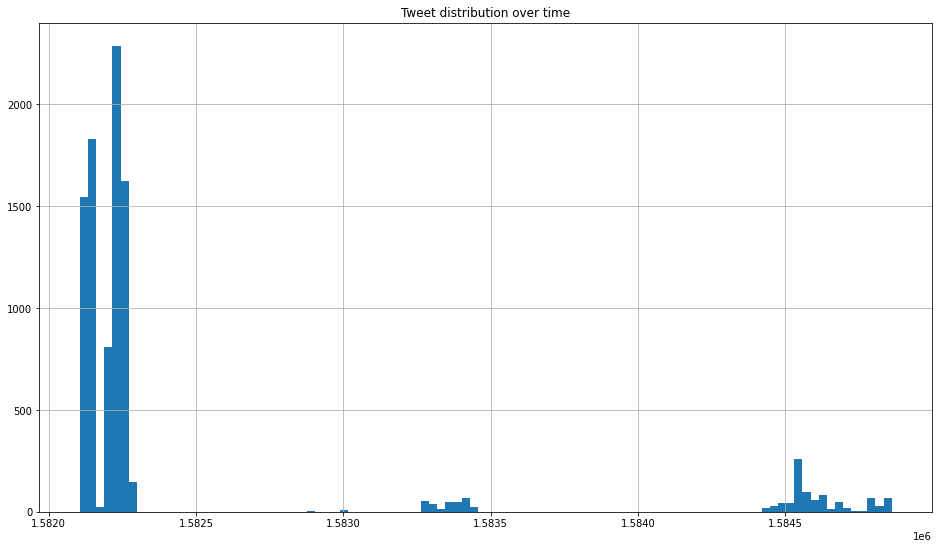

In [6]:
dates.hist(bins=100, figsize=FIGURE_SIZE)
plt.title('Tweet distribution over time')
plt.show()

## Cleaning
- Remove
    - All urls
    - '#' form infront of hashtags
    - mentions
    - emojis
    - Non ASCII chanracters

In [7]:
import re
import preprocessor as p

# Don't remove hastags
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.NUMBER, p.OPT.SMILEY, p.OPT.RESERVED, p.OPT.MENTION)

NOT_BASIC_LATIN_PATTERN = re.compile(u'[^\u0000-\u007F]')
PUNCTUATIONS_PATTERN = re.compile(r'[\#\$\%\&\(\)\*\+\-\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]')
MULTIPLE_SPACES_PATTERN = re.compile(r' +')

def clean_text(text):
    text = text.lower()
    text = p.clean(text) # Clean using tweet-preprocessor except hashtags
    text = NOT_BASIC_LATIN_PATTERN.sub(' ', text) # Remove everything except basic latin
    text = re.sub(r'&amp;', 'and', text)
    text = PUNCTUATIONS_PATTERN.sub(' ', text) # Remove all punctuations
    text = MULTIPLE_SPACES_PATTERN.sub(' ', text) # Remove multiple consequent spaces
    return text.strip()

In [8]:
%%time
tweets['clean_text'] = tweets['text'].apply(lambda x: clean_text(x))
tweets[['text','clean_text']].head()

CPU times: user 1.06 s, sys: 15.6 ms, total: 1.08 s
Wall time: 1.08 s


,text,clean_text
0,@DanielNewman @SpaceAdventures @SpaceX But sur...,"but sure, lets just not travel to space where ..."
1,CNN: SpaceX has signed a deal with a space tou...,cnn spacex has signed a deal with a space tour...
2,Watch SpaceX attempt a rocket reusability reco...,watch spacex attempt a rocket reusability reco...
3,SpaceX has signed a deal with a space tourism ...,spacex has signed a deal with a space tourism ...
4,@IsChinar I'm pretty sure #Spacex didnt exist ...,i'm pretty sure spacex didnt exist in or any o...


## Analysis of words used in cleaned tweets

### Most used words

In [9]:
import nltk
from nltk.text import Text
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

tokenizer = TweetTokenizer()

all_clean_text = []
for text in tweets['clean_text']:
    for t in tokenizer.tokenize(text):
        all_clean_text.append(t)
all_clean_text = Text(all_clean_text)

In [10]:
freq_dist = nltk.FreqDist(all_clean_text)

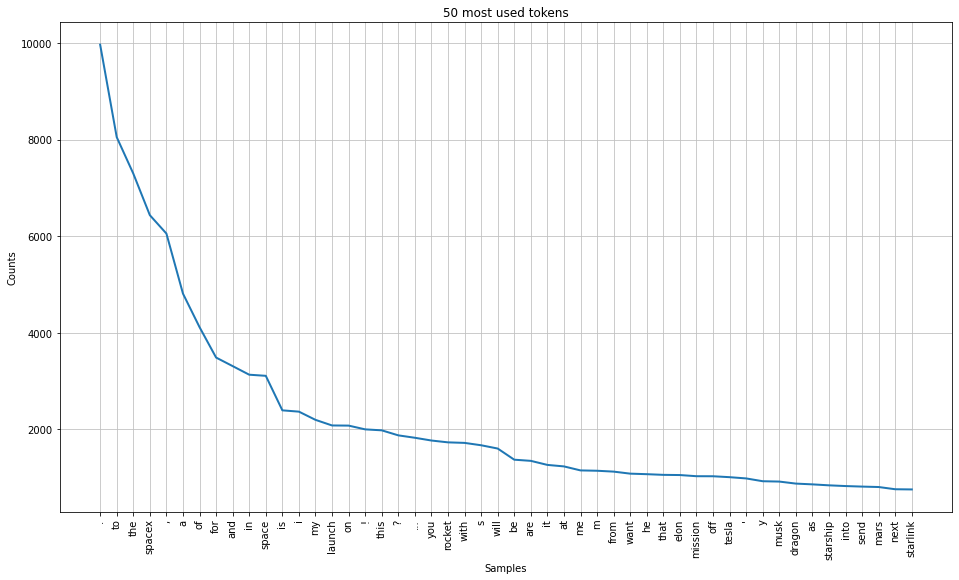

In [11]:
plt.figure(figsize=FIGURE_SIZE)
freq_dist.plot(50, title="50 most used tokens")

### Most used words after removing stop words and punctuations

In [12]:
# nltk.download('stopwords')

from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

# Add 'google' and 'search' in stop words
stop_words.add('google')
stop_words.add('search')
# Remove stopwords
freq_dist = nltk.FreqDist(dict((word, freq) for word, freq in freq_dist.items() if word not in stop_words and word.isalpha()))

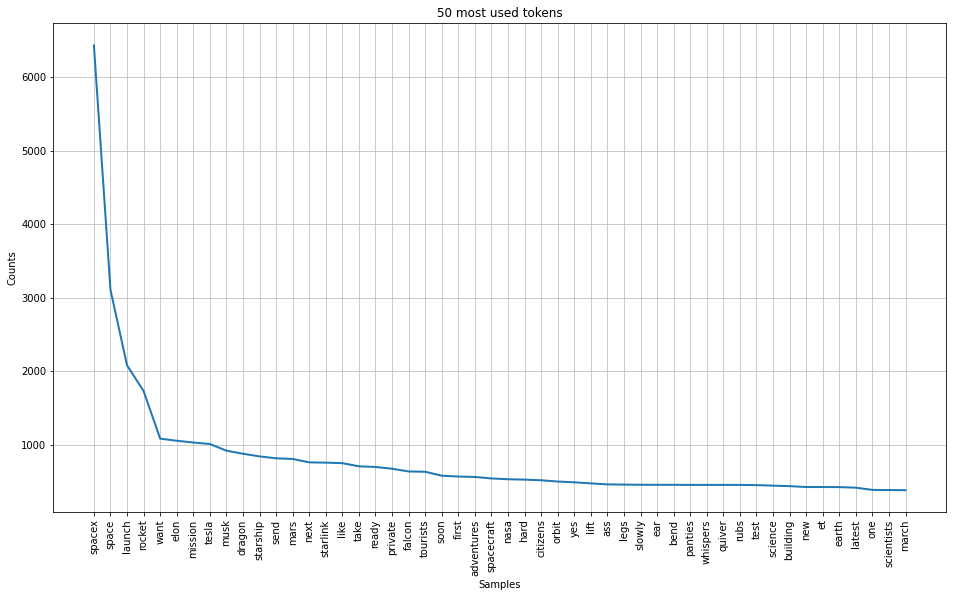

In [13]:
plt.figure(figsize=FIGURE_SIZE)
freq_dist.plot(50, title="50 most used tokens")

## Feature Creation

### 'is_retweet' from 'tweet_source' and 'tweet_id'

In [14]:
def is_retweet(x):
    return x[0] != x[1]

In [15]:
tweets['is_retweet'] = tweets[['tweet_source','tweet_id']].apply(lambda x: is_retweet(x), axis=1)

In [16]:
tweets[['tweet_source','tweet_id','is_retweet']].head()

,tweet_source,tweet_id,is_retweet
0,1230070629044543489,1230070629044543489,False
1,1230070817041666048,1230070817041666048,False
2,1230070827984543744,1230070827984543744,False
3,1230043100296491010,1230071037057851392,True
4,1230071206063300609,1230071206063300609,False


### 'hashtags' from 'text'

In [17]:
HASHTAG_PATTERN = re.compile(r'#\w*')
def get_hashtags(text):
    return ' '.join(HASHTAG_PATTERN.findall(text))

In [18]:
tweets['hashtags'] = tweets['text'].apply(lambda x: get_hashtags(x))

In [19]:
tweets[['text','hashtags']].head()

,text,hashtags
0,@DanielNewman @SpaceAdventures @SpaceX But sur...,
1,CNN: SpaceX has signed a deal with a space tou...,
2,Watch SpaceX attempt a rocket reusability reco...,
3,SpaceX has signed a deal with a space tourism ...,
4,@IsChinar I'm pretty sure #Spacex didnt exist ...,#Spacex #Firmament #Electromagnitism #nasalies...


## Sentiment Analysis

In [47]:
def get_polarity(text):
    return TextBlob(text).polarity

def get_sentiment(text):
    return TextBlob(text).sentiment

In [48]:
%%time
sentiment = tweets['clean_text'].apply(lambda x: get_sentiment(x))
tweets['polarity'] = sentiment.apply(lambda x: x[0])
tweets['subjectivity'] = sentiment.apply(lambda x: x[1])

CPU times: user 6.03 s, sys: 46.9 ms, total: 6.08 s
Wall time: 6.07 s


In [49]:
tweets[['clean_text','polarity','subjectivity']].head()

,clean_text,polarity,subjectivity
0,"but sure, lets just not travel to space where ...",0.152841,0.540972
1,cnn spacex has signed a deal with a space tour...,0.100000,0.750000
2,watch spacex attempt a rocket reusability reco...,0.136364,0.500000
3,spacex has signed a deal with a space tourism ...,0.100000,0.750000
4,i'm pretty sure spacex didnt exist in or any o...,0.356250,0.740972


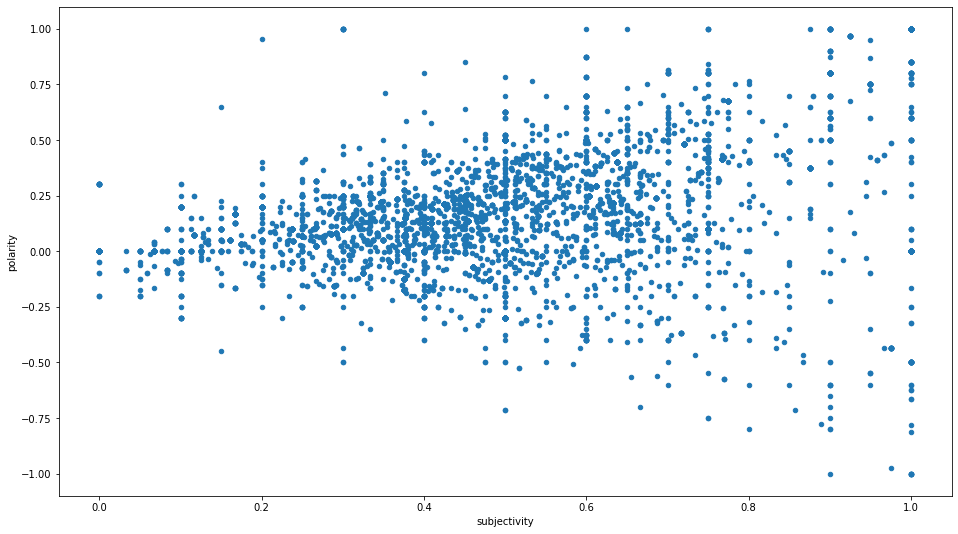

In [50]:
tweets[['polarity','subjectivity']].plot(kind='scatter', x='subjectivity', y='polarity',figsize=FIGURE_SIZE)

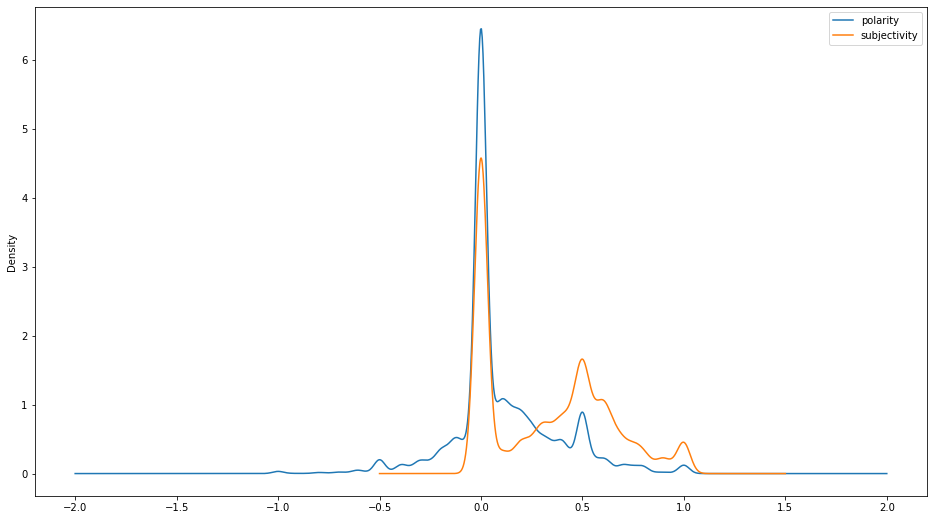

In [54]:
tweets[['polarity','subjectivity']].plot(figsize=FIGURE_SIZE, kind='density')

### Sentiment Over Time

In [55]:
def get_datetime(ts):
    return datetime.fromtimestamp(ts)

In [56]:
# Add datetime column
tweets['datetime'] = tweets['timestamp'].apply(lambda x: get_datetime(x))

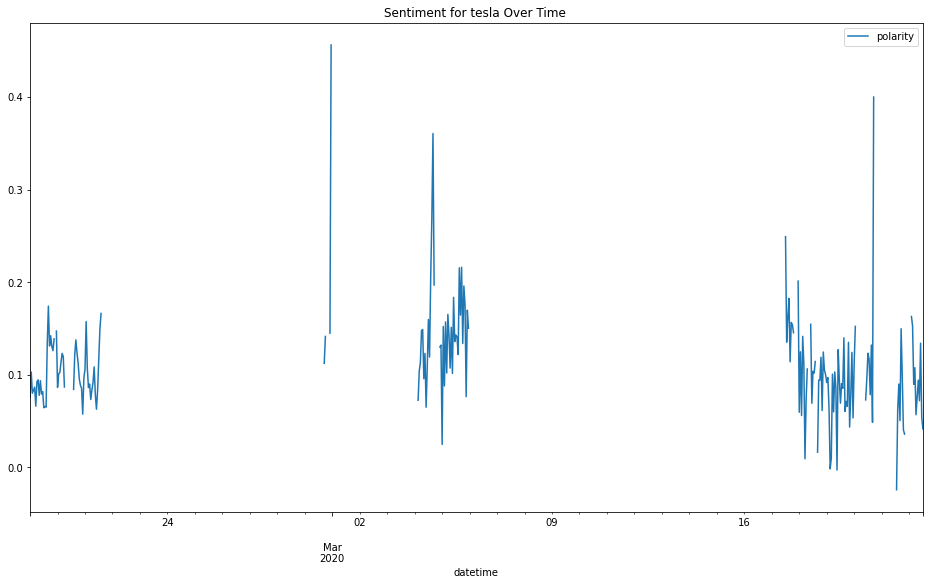

In [57]:
tweets[['datetime','polarity']].groupby(pd.Grouper(key='datetime', freq='H')).mean().plot(figsize=FIGURE_SIZE)
plt.title(f'Sentiment for {TARGET} Over Time ')
plt.show()

### Top Twitter Clients

In [58]:
client_popularity = tweets[['polarity','source_device']].groupby('source_device').size().sort_values(ascending=False)

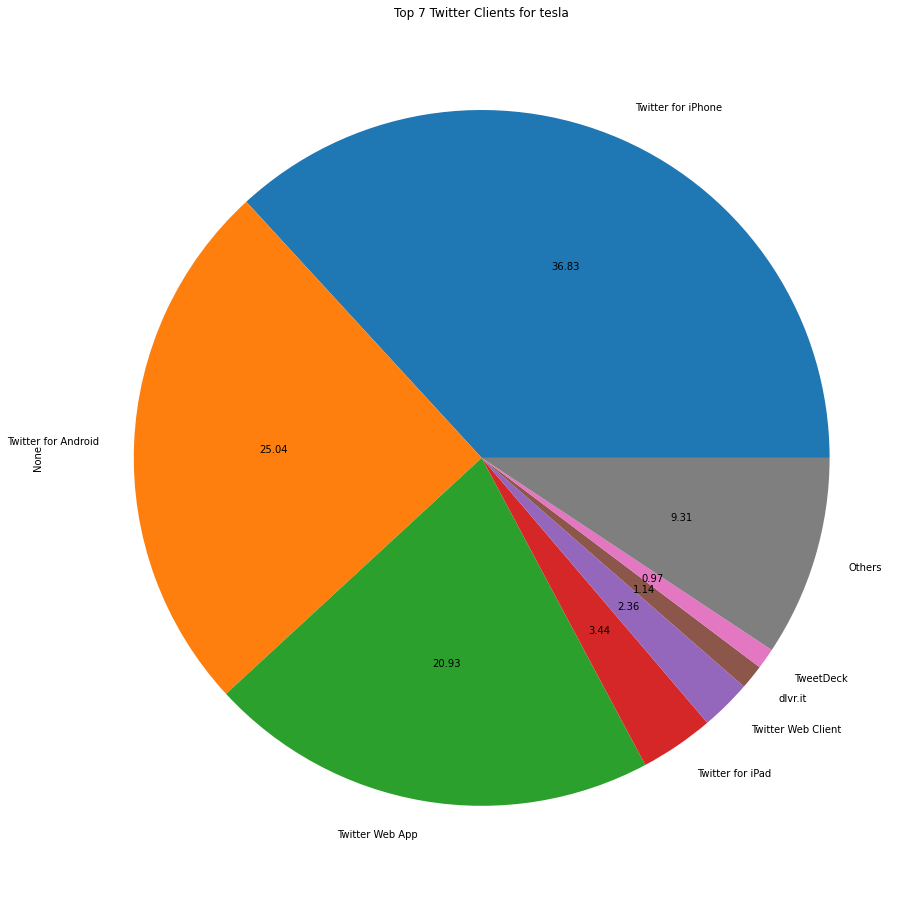

In [59]:
client_popularity[:7].append(pd.Series(client_popularity[7:].sum(), index=['Others'])).plot(kind='pie', autopct='%.2f', figsize=(16,16))
plt.title(f'Top 7 Twitter Clients for {TARGET}')
plt.show()

### Average Sentiment of people using particulat twitter clients

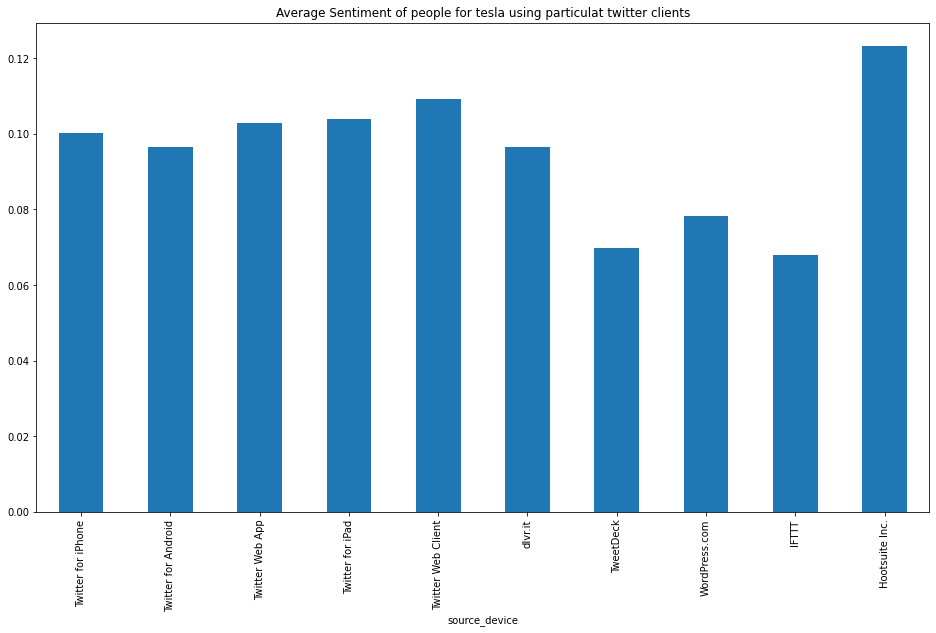

In [60]:
tweets[['datetime','polarity','source_device']].groupby('source_device').agg({
    'polarity': ['size', 'mean']
}).sort_values(('polarity','size'), ascending=False)[('polarity','mean')][:10].plot(kind='bar', figsize=FIGURE_SIZE)
plt.title(f'Average Sentiment of people for {TARGET} using particular twitter clients')
plt.show()